# Sentiment analysis of movie reviews

Addison 2024-04-10

## I. Introduction

This project aims to build a model to predict the sentiment of movie reviews as either positive or negative. The dataset used for this task contains 50,000 reviews.

The dataset can be obtained through this link:

https://ai.stanford.edu/~amaas/data/sentiment/

The dataset comprises two columns. Since it lacks a header row, we will assign names to the columns: **review** and **sentiment**:

- **review:** the content of the review

- **sentiment:**  the category of the movie review, which can be either positive or negative.

## II. Exploring the data

First, let's import the necessary libraries!

In [1]:
import tarfile
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim.downloader as api

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


Now, we'll download the dataset from the URL below.

In [2]:
# The URL of the dataset
URL = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

# Download and extract the dataset
dataset = tf.keras.utils.get_file(
    fname='aclImdb_v1.tar.gz',
    origin=URL,
    untar=True,
    cache_dir='.',
    cache_subdir=''
)

After that, we'll extract data from the downloaded file and store it into one variable named **'data'**. Then, we'll create a dataframe called **'df'** from the variable **'data'**.

In [3]:
# Path to the downloaded tar.gz file
tar_file_path = './aclImdb_v1.tar.gz'

# Extract the contents of the tar.gz file
with tarfile.open(tar_file_path, 'r:gz') as tar:
    tar.extractall()

# After extraction, the files are stored in a directory named 'aclImdb'

# Define an empty list to store the data
data = []

# Iterate over the directories containing the extracted data
for category in ['train', 'test']:
    for sentiment in ['pos', 'neg']:
        folder_path = os.path.join('aclImdb', category, sentiment)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                data.append([text, sentiment])

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=['review', 'sentiment'])
df.head()

,review,sentiment
0,"Chang Cheh's ""Shaolin Temple"" might very well ...",pos
1,"I had some reservations about this movie, I fi...",pos
2,"The first of the official Ghibli films, Laputa...",pos
3,Eleven different Film Makers from different pa...,pos
4,"Once you can get past the film's title, ""Pecke...",pos


After taking a brief glance at the initial rows of the data, we'll now explore the data types of the columns and the count of non-null entries in each column.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


There are no null values in the dataset. Next, we'll examine the frequency of each value in the **'sentiment'** column.

In [5]:
df['sentiment'].value_counts()

sentiment
pos    25000
neg    25000
Name: count, dtype: int64

The **sentiment** column exhibits equal frequency for each value, suggesting a **balanced distribution** of sentiment classes within the dataset.

## III. Constructing a RNN sentiment prediction model

### 3.1 Selecting a pre-trained model

In this project, we'll utilize the **FastText word embeddings**. These pre-trained embeddings provide rich semantic representations of words, facilitating tasks such as sentiment analysis or text classification. Next, we'll load the FastText word embeddings into variable **word_vectors**.


In [6]:
# Load FastText word embeddings
word_vectors = api.load("fasttext-wiki-news-subwords-300")

### 3.2 Create embedding matrix

Next, we'll use the function **create_embedding_matrix** to generate an embedding matrix that assigns each word in the word index its corresponding embedding vector. In simpler terms, this process involves searching for each word in a large database of word meanings and then arranging these meanings into a list in a particular order

In [7]:
def create_embedding_matrix(word_index, embedding_dim):
    # Initialize an empty matrix to store the embedding vectors
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

    # Iterate over each word in the word index
    for word, i in word_index.items():
        try:
            # Try to retrieve the embedding vector for the current word
            embedding_vector = word_vectors[word]

            # If the embedding vector exists, assign it to the corresponding row in the embedding matrix
            embedding_matrix[i] = embedding_vector
        except KeyError:
            # If the embedding vector does not exist (i.e., the word is not in the embedding vocabulary), skip it
            pass

    # Return the resulting embedding matrix
    return embedding_matrix

### 3.3 Splitting the data into training and testing sets

Afterwards, we'll split the dataset into training and testing sets and allocate 20% of the data for testing.

In [8]:
# Split the data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['review'], df['sentiment'],
                                                                      test_size=0.2, random_state=777)

### 3.4 Converting text to sequences

Next, we'll initialize a **tokenizer** to process text data by converting words into numerical representations. In this instance, the tokenizer considers only the **10,000 most frequent words** in the dataset, disregarding less common ones. This approach aids in managing memory usage and emphasizes the most relevant words for the task at hand.

After that, we'll fit the tokenizer to the training text data and convert both the training and testing text data into sequences of word indices.

In [9]:
# Convert text to sequences

# Initialize a tokenizer with a maximum vocabulary size of 10,000 words
tokenizer = Tokenizer(num_words=10000)

# Fit the tokenizer on the training text data
tokenizer.fit_on_texts(train_texts)

# Convert training text data to sequences of word indices
train_sequences = tokenizer.texts_to_sequences(train_texts)

# Convert testing text data to sequences of word indices
test_sequences = tokenizer.texts_to_sequences(test_texts)

### 3.5 Sequence padding

In this project, we'll set the **maximum length for sequences to be 200**, which is necessary for feeding the data into a neural network model for training and evaluation.

All the sequences in both the training and testing sets will be padded or truncated to have a length of 200.

In [10]:
# Pad sequences to have the same length

# Define the maximum sequence length to be 200
maxlen = 200

# Pad training sequences to have a length of 200
train_sequences = pad_sequences(train_sequences, maxlen=maxlen)

# Pad testing sequences to have a length of 200
test_sequences = pad_sequences(test_sequences, maxlen=maxlen)

### 3.6 Preparing the embedding matrix

In this project, we'll ensure that each word embedding vector has a dimensionality of 300. This means that each word will be represented by a vector of 300 numerical values. Then, we'll create the embedding matrix using pre-trained word embeddings. In this case, each word will still be represented by a vector of 300 numerical values. In simpler terms, each word is associated with 300 pieces of information that capture its usage patterns and relationships with other words in the dataset.

In [11]:
embedding_dim = 300  # Each word embedding vector will have a dimensionality of 300

# Create the embedding matrix using pre-trained word embeddings
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dim)

### 3.7 Defining the model

Next, we'll structure a **Recurrent Neural Network (RNN)** model with the following components:

- First, we'll convert input sequences of word indices into dense vectors of fixed size (embedding_dim).
- Second, we'll utilize **Bidirectional LSTM layers with 64 and 32 units** to process input sequences in both forward and backward directions, enabling the model to capture dependencies from both past and future contexts.
- Third, we'll incorporate a **Dense layer with 64 neurons and ReLU activation function** to extract and learn complex patterns and features from the input sequences.
- Fourth, to prevent overfitting, we'll include a **Dropout layer** that randomly sets 50% of input units to zero during training.
- Finally, we'll employ a **Dense layer with 1 neuron and Sigmoid activation function** for binary classification.

In [12]:
# Define the model
model_1 = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim,
              input_length=maxlen, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

Next, we'll **configure the model for training:**
- **Optimizer:** 'adam' -  Adaptive Moment Estimation. It will adjust the learning rate during training.
- **Loss function:** Binary Crossentropy. This loss function is suitable for binary classification problems.
- **Metrics:** 'accuracy' will measure the proportion of correctly classified examples.

In [13]:
# Compile the model
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Now, we're going to **train the model** on the training set and **validate it** on the validation set. For this project, we'll use **10 epochs** to strike a balance between underfitting and overfitting. 10 epochs also provide the model with sufficient training time to learn from the training data.

In [14]:
num_epoch = 10

# Train the model
history = model_1.fit(train_sequences, np.array(train_labels == 'pos'), epochs=num_epoch,
                    batch_size=64, validation_split=0.2)

Epoch 1/10
500/500 [==============================] - 26s 37ms/step - loss: 0.4876 - accuracy: 0.7632 - val_loss: 0.3953 - val_accuracy: 0.8163
Epoch 2/10
500/500 [==============================] - 17s 34ms/step - loss: 0.4071 - accuracy: 0.8232 - val_loss: 0.3671 - val_accuracy: 0.8388
Epoch 3/10
500/500 [==============================] - 16s 32ms/step - loss: 0.3631 - accuracy: 0.8451 - val_loss: 0.3629 - val_accuracy: 0.8447
Epoch 4/10
500/500 [==============================] - 16s 32ms/step - loss: 0.3344 - accuracy: 0.8593 - val_loss: 0.3212 - val_accuracy: 0.8591
Epoch 5/10
500/500 [==============================] - 17s 34ms/step - loss: 0.3028 - accuracy: 0.8742 - val_loss: 0.3046 - val_accuracy: 0.8668
Epoch 6/10
500/500 [==============================] - 17s 34ms/step - loss: 0.2880 - accuracy: 0.8816 - val_loss: 0.2992 - val_accuracy: 0.8730
Epoch 7/10
500/500 [==============================] - 16s 32ms/step - loss: 0.2732 - accuracy: 0.8893 - val_loss: 0.2904 - val_accuracy:

Now, we're going to **evaluate the trained model on a test set.**

In [15]:
# Evaluate the model
loss, accuracy = model_1.evaluate(test_sequences, np.array(test_labels == 'pos'))
print(f'Test Accuracy: {accuracy}')

313/313 [==============================] - 5s 13ms/step - loss: 0.3033 - accuracy: 0.8834
Test Accuracy: 0.883400022983551


The accuracy score of model_1 is relatively high.

### 3.8 Training & Validation Loss and Accuracy Visualization

In this section, we'll plot Training & Validation Loss and Accuracy to evaluate the model performance.

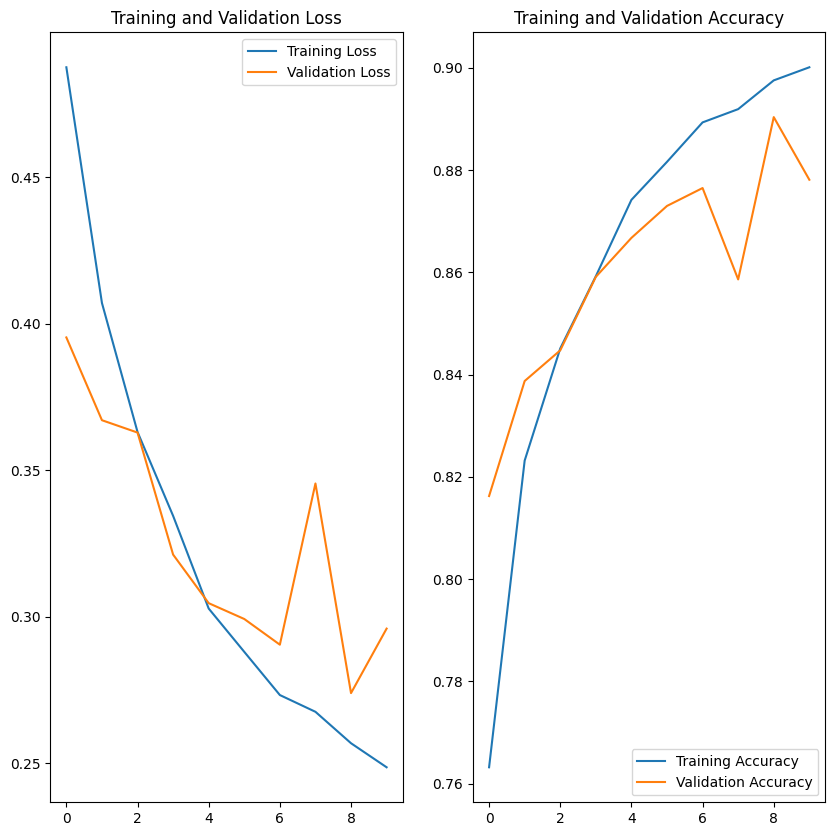

In [16]:
# Extracting loss and accuracy metrics from the training history

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(range(num_epoch), loss, label = 'Training Loss')
plt.plot(range(num_epoch), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(range(num_epoch), accuracy, label = 'Training Accuracy')
plt.plot(range(num_epoch), val_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

Based on the graphs, it's evident that:
- The **training loss decreases steadily over epochs**, indicating that the model is learning the underlying patterns in the data.
- The **validation loss also tends to decrease along with the training loss**, indicating that the model is generalizing well to unseen data.
- The **training accuracy increases steadily** as the model learns from the training data.
- Similarly, the **validation accuracy tends to increase along with the training accuracy**, indicating that the model is performing well on unseen data.

Thus, it can be concluded that **model_1** has achieved a **good fit**.

## IV. Constructing a hybrid RNN & CNN sentiment prediction model

### 4.1 Adding CNN layers to the model

In this section, we'll explore the integration of Convolutional Neural Network (CNN) layers into our existing model_1 to evaluate whether this technique improves our current model. By combining CNN and RNN layers, the model can capture hierarchical representations of the input data. **CNN layers excel at extracting low-level features, while RNN layers specialize in learning dependencies and relationships across longer sequences.** This combination enables the model to capture both local and global contextual information. 

Specifically, we'll **insert a 1D convolutional layer and a max pooling layer** between two Bidirectional layers. The **remaining hyperparameters** such as tokenizer, maxlen, and embedding_dim, remain **unchanged**. Then, we'll train the hybrid model (model_2) and evaluate its accuracy using 10 epochs.

In [17]:
train_texts_2, test_texts_2, train_labels_2, test_labels_2 = train_test_split(df['review'], df['sentiment'],
                                                                      test_size=0.2, random_state=777)

# Initialize a tokenizer with a maximum vocabulary size of 10,000 words
tokenizer_2 = Tokenizer(num_words=10000)

# Fit the tokenizer on the training text data
tokenizer_2.fit_on_texts(train_texts_2)

# Convert training text data to sequences of word indices
train_sequences_2 = tokenizer_2.texts_to_sequences(train_texts_2)

# Convert testing text data to sequences of word indices
test_sequences_2 = tokenizer_2.texts_to_sequences(test_texts_2)


# Define the maximum sequence length to be 200
maxlen = 200

# Pad training sequences to have a length of 200
train_sequences_2 = pad_sequences(train_sequences_2, maxlen=maxlen)

# Pad testing sequences to have a length of 200
test_sequences_2 = pad_sequences(test_sequences_2, maxlen=maxlen)

# Define the dimensionality of the word embeddings
embedding_dim = 300  # Each word embedding vector will have a dimensionality of 300

# Create the embedding matrix using pre-trained word embeddings
embedding_matrix_2 = create_embedding_matrix(tokenizer_2.word_index, embedding_dim)

# Define the model

model_2 = Sequential([
    Embedding(input_dim=len(tokenizer_2.word_index) + 1, output_dim=embedding_dim,
              input_length=maxlen, weights=[embedding_matrix_2], trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Conv1D(128, 5, activation='relu'),  # Add a 1D convolutional layer
    MaxPooling1D(5),  # Add max pooling layer
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history = model_2.fit(train_sequences_2, np.array(train_labels_2 == 'pos'), epochs=num_epoch, batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = model_2.evaluate(test_sequences_2, np.array(test_labels_2 == 'pos'))
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
500/500 [==============================] - 23s 31ms/step - loss: 0.4515 - accuracy: 0.7832 - val_loss: 0.3209 - val_accuracy: 0.8611
Epoch 2/10
500/500 [==============================] - 13s 25ms/step - loss: 0.3096 - accuracy: 0.8717 - val_loss: 0.3540 - val_accuracy: 0.8426
Epoch 3/10
500/500 [==============================] - 13s 25ms/step - loss: 0.2762 - accuracy: 0.8879 - val_loss: 0.2714 - val_accuracy: 0.8838
Epoch 4/10
500/500 [==============================] - 12s 25ms/step - loss: 0.2560 - accuracy: 0.8958 - val_loss: 0.2636 - val_accuracy: 0.8924
Epoch 5/10
500/500 [==============================] - 12s 25ms/step - loss: 0.2379 - accuracy: 0.9049 - val_loss: 0.2560 - val_accuracy: 0.8934
Epoch 6/10
500/500 [==============================] - 12s 25ms/step - loss: 0.2195 - accuracy: 0.9142 - val_loss: 0.2469 - val_accuracy: 0.8960
Epoch 7/10
500/500 [==============================] - 13s 25ms/step - loss: 0.2057 - accuracy: 0.9187 - val_loss: 0.2620 - val_accuracy:

The accuracy score of model_2 is relatively high, however, slightly lower than that of model_1.

### 4.2 Training & Validation Loss and Accuracy Visualization

In this section, we'll plot Training & Validation Loss and Accuracy to evaluate the model performance.

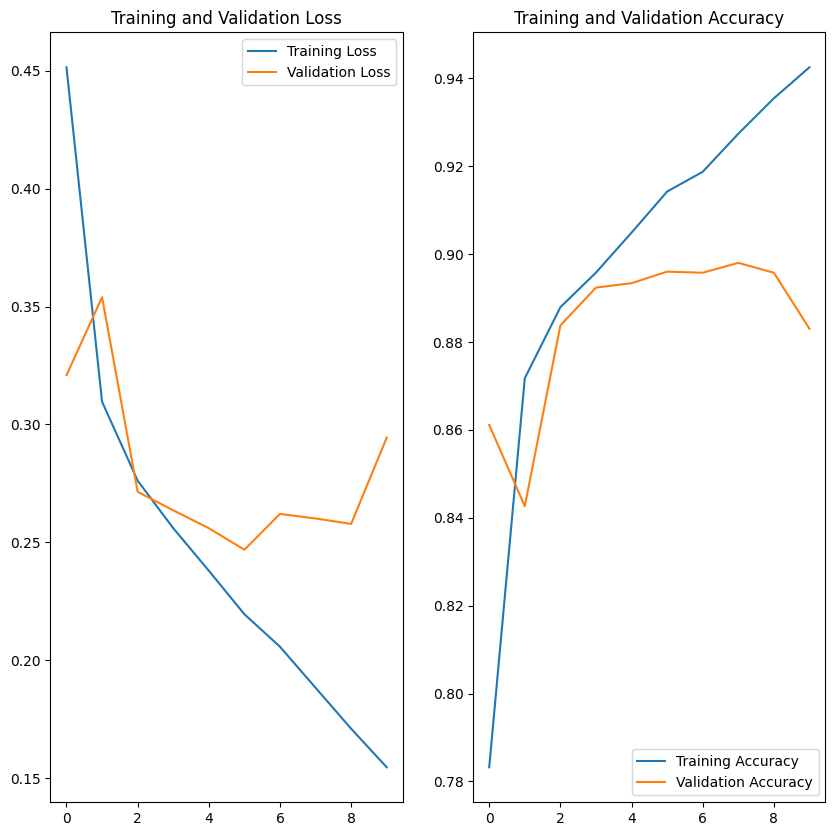

In [18]:
# Extracting loss and accuracy metrics from the training history

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(range(num_epoch), loss, label = 'Training Loss')
plt.plot(range(num_epoch), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(range(num_epoch), accuracy, label = 'Training Accuracy')
plt.plot(range(num_epoch), val_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

Based on the graphs, it's evident that:
- The **training loss decreases steadily over epochs**, indicating that the model is learning the underlying patterns in the data.
- The **validation loss fluctuates significantly and tends to increase compared to the training loss from epoch 5 onwards**. This indicates that the model may not be generalizing well to unseen data, as the validation loss should ideally decrease or remain stable over epochs.
- The **training accuracy increases steadily** as the model learns from the training data.
- Conversely, the **validation accuracy tends to decrease towards the end of training**, implying that the model's performance on unseen data is not as robust.

Given these observations, it's possible that **model_2** is **slightly overfitting**, as indicated by the decreasing trend in validation accuracy and the increasing trend in validation loss compared to training loss.

## V. Training the model with preprocessing texts
### 5.1 Preprocessing texts
In this section, we aim to enhance the accuracy of our classification model by preprocessing the review texts. 

We introduce a function called **preprocess_text**, designed to standardize the format of the text data. This function follows a series of steps: 
- converting text to lowercase
- removing special characters, numbers, and punctuation 
- tokenizing the text into individual words
- excluding common but insignificant words (such as "the" or "and")
- reducing words to their base form (e.g., converting "running" to "run")

The processed words are then reassembled into clean, preprocessed text, facilitating further analysis.

In [19]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Apply the preprocess_text function to the 'text' column of the DataFrame
df['preprocessed_text'] = df['review'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 5.2 Training the model

Next, we'll **select model_1 to train with preprocessed reviews**, as it has demonstrated better performance compared to model_2. To distinguish between the original model_1 trained on raw reviews and the new model trained on preprocessed reviews, we'll refer to the latter as **model_3**. The **remaining hyperparameters**, such as tokenizer, maxlen, and embedding_dim, will remain **unchanged**.

In [20]:
# Split the data into training and testing sets
train_texts_3, test_texts_3, train_labels_3, test_labels_3 = train_test_split(df['preprocessed_text'], df['sentiment'],
                                                                      test_size=0.2, random_state=777)

# Initialize a tokenizer with a maximum vocabulary size of 10,000 words
tokenizer_3 = Tokenizer(num_words=10000)

# Fit the tokenizer on the training text data
tokenizer_3.fit_on_texts(train_texts_3)

# Convert training text data to sequences of word indices
train_sequences_3 = tokenizer_3.texts_to_sequences(train_texts_3)

# Convert testing text data to sequences of word indices
test_sequences_3 = tokenizer_3.texts_to_sequences(test_texts_3)


# Define the maximum sequence length to be 200
maxlen = 200

# Pad training sequences to have a length of 200
train_sequences_3 = pad_sequences(train_sequences_3, maxlen=maxlen)

# Pad testing sequences to have a length of 200
test_sequences_3 = pad_sequences(test_sequences_3, maxlen=maxlen)

# Define the dimensionality of the word embeddings
embedding_dim = 300  # Each word embedding vector will have a dimensionality of 300

# Create the embedding matrix using pre-trained word embeddings
embedding_matrix_3 = create_embedding_matrix(tokenizer_3.word_index, embedding_dim)

# Define the model
model_3 = Sequential([
    Embedding(input_dim=len(tokenizer_3.word_index) + 1, output_dim=embedding_dim,
              input_length=maxlen, weights=[embedding_matrix_3], trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history = model_3.fit(train_sequences_3, np.array(train_labels_3 == 'pos'), epochs=num_epoch,
                      batch_size=64, validation_split=0.2)

# Evaluate the model
loss, accuracy = model_3.evaluate(test_sequences_3, np.array(test_labels_3 == 'pos'))
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
500/500 [==============================] - 24s 36ms/step - loss: 0.4555 - accuracy: 0.7860 - val_loss: 0.3810 - val_accuracy: 0.8339
Epoch 2/10
500/500 [==============================] - 18s 35ms/step - loss: 0.3770 - accuracy: 0.8392 - val_loss: 0.3687 - val_accuracy: 0.8451
Epoch 3/10
500/500 [==============================] - 16s 32ms/step - loss: 0.3556 - accuracy: 0.8516 - val_loss: 0.3660 - val_accuracy: 0.8415
Epoch 4/10
500/500 [==============================] - 17s 35ms/step - loss: 0.3591 - accuracy: 0.8498 - val_loss: 0.4361 - val_accuracy: 0.7969
Epoch 5/10
500/500 [==============================] - 18s 35ms/step - loss: 0.3254 - accuracy: 0.8666 - val_loss: 0.3374 - val_accuracy: 0.8515
Epoch 6/10
500/500 [==============================] - 17s 34ms/step - loss: 0.3128 - accuracy: 0.8722 - val_loss: 0.3312 - val_accuracy: 0.8625
Epoch 7/10
500/500 [==============================] - 17s 34ms/step - loss: 0.3027 - accuracy: 0.8756 - val_loss: 0.3250 - val_accuracy:

The accuracy score of model_3 is lower than that of both model_1 and model_2, indicating that the preprocessing step does not improve the model's performance.

### 5.3 Training & Validation Loss and Accuracy Visualization


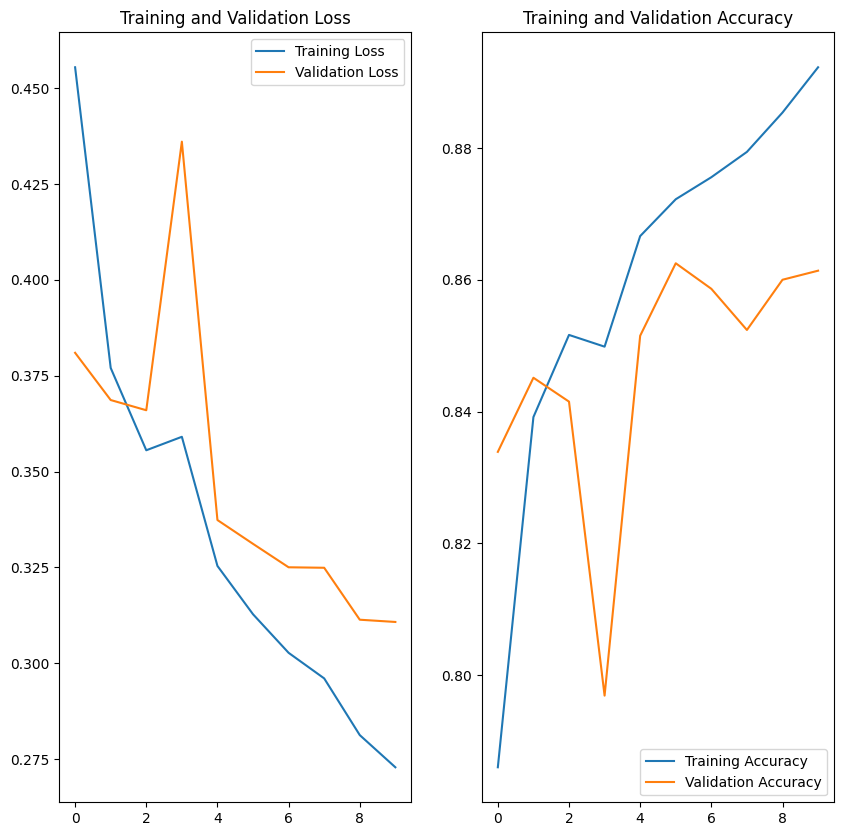

In [21]:
# Extracting loss and accuracy metrics from the training history

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(range(num_epoch), loss, label = 'Training Loss')
plt.plot(range(num_epoch), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(range(num_epoch), accuracy, label = 'Training Accuracy')
plt.plot(range(num_epoch), val_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

Based on the graphs, it's evident that:
- The **training loss decreases steadily over epochs**, indicating that the model is learning the underlying patterns in the data.
- The **validation loss also tends to decrease along with the training loss**, indicating that the model is generalizing well to unseen data. there is a larger gap between the validation loss and training loss compared to model_1.
- The **training accuracy increases steadily** as the model learns from the training data.
- Similarly, the **validation accuracy tends to increase along with the training accuracy**, indicating that the model is performing well on unseen data. However, there is a larger gap between the validation accuracy and training accuracy compared to model_1.

While **model_3** achieves a **good fit**, model_1 demonstrates better performance with a higher accuracy score. Therefore, **model_1 is considered the optimal choice** for predicting sentiment in movie reviews for this project.

## VI. Creating a function for single prediction

Now, we're going to create a function named **predict_sentiment** that takes a review text as input, and returns the predicted sentiment. We'll test the function with two examples.

In [22]:
def predict_sentiment(review_text):

    # Tokenize the input review text
    sequence = tokenizer.texts_to_sequences([review_text])
    # Pad the sequence to the defined maximum length
    sequence = pad_sequences(sequence, maxlen)
    # Make the prediction using the model
    prediction = model_1.predict(sequence)
    # Convert the prediction to 'pos' or 'neg'
    sentiment = 'positive' if prediction >= 0.5 else 'negative'
    return sentiment

# Example usage:
review_text = "This movie was fantastic! I loved every moment of it."
sentiment = predict_sentiment(review_text)
print(f"The predicted sentiment for the review is: {sentiment}")

1/1 [==============================] - 1s 1s/step
The predicted sentiment for the review is: positive


In [23]:
review_text_2 = "The movie was terrible. I regret watching it."
sentiment = predict_sentiment(review_text_2)
print(f"The predicted sentiment for the review is: {sentiment}")

1/1 [==============================] - 0s 26ms/step
The predicted sentiment for the review is: negative


The function produces expected result!

## VII. Conclusions and suggestions for future research

In conclusion, the sentiment prediction models developed in this project showed promising performance in classifying movie reviews as positive or negative. Model_1, which utilized a Bidirectional LSTM architecture, demonstrated particularly strong accuracy in predicting sentiment. However, incorporating additional preprocessing steps, such as text normalization or handling imbalanced data, did not significantly improve model performance.

For future research, several avenues could be explored to further enhance the model's effectiveness:

- **Fine-tuning Hyperparameters**: Experimenting with different hyperparameter configurations, such as adjusting the number of LSTM units or exploring different embedding dimensions, could help optimize model performance.

- **Exploring Advanced Architectures**: Investigating more complex architectures, such as attention mechanisms or transformer-based models like BERT, could potentially capture more intricate patterns in the text data and improve classification accuracy.